In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('pricing_data.csv')

In [3]:
data.shape

(50000, 11)

In [4]:
data.head()

,product_id,benchmark_price_1,benchmark_price_2,benchmark_price_3,benchmark_price_4,benchmark_price_5,benchmark_price_6,category,manufacturer_id,shipping_profile,target_price
0,0,34.75,NaN,NaN,NaN,15.99,26.645,Electronics,8102,SP-9.99,21.99
1,1,785.65,453.99,409.28,NaN,NaN,NaN,Electronics,56,SP-9.99,469.99
2,2,699.99,NaN,NaN,NaN,NaN,NaN,Electronics,1,SP-11.99,655.99
3,3,NaN,NaN,NaN,NaN,NaN,81.990,Home & Garden,2677,SP-19.99,67.49
4,4,19.42,NaN,9.63,NaN,NaN,NaN,Home & Garden,3103,SP-9.99,24.99


In [5]:
data.describe()

,product_id,benchmark_price_1,benchmark_price_2,benchmark_price_3,benchmark_price_4,benchmark_price_5,benchmark_price_6,manufacturer_id,target_price
count,50000.000000,38495.000000,10296.000000,31734.000000,12952.000000,20154.000000,18578.000000,50000.000000,50000.000000
mean,24999.500000,142.716291,54.802792,64.753260,52.268570,75.355332,102.377382,49187.006880,75.338862
std,14433.901067,313.140358,153.981676,157.667167,105.175118,184.665383,250.813825,51039.182438,179.395264
min,0.000000,1.000000,0.530000,0.200000,0.490000,0.980000,0.990000,1.000000,2.090000
25%,12499.750000,30.005000,16.280000,20.000000,19.990000,20.590000,21.270000,4283.000000,18.990000
50%,24999.500000,59.990000,26.030000,31.990000,30.055000,35.000000,39.980000,27073.000000,29.990000
75%,37499.250000,129.000000,45.590000,55.900000,49.990000,65.000000,86.797500,87797.000000,56.990000
max,49999.000000,8905.000000,4899.990000,6899.990000,2599.990000,7997.000000,7997.000000,166413.000000,7994.990000


This initial description tells us that benchmark_price2,4,5 and 6 have more than 50% missing values. A simple strategy like mean imputation may do more harm than good in this case , since it might change the data distribution.

### Analysing the distribution of category. Is One hot encoding possible or will it bloat the dimensionality?

In [6]:
len(data.category.unique())

6

In [7]:
data.category.value_counts()

Clothing & Accessories    15980
Home & Garden             12428
Electronics                7592
Health & Fitness           7225
More ...                   3677
Toys & Baby                3098
Name: category, dtype: int64

In [8]:
len(data.shipping_profile.unique())

9

In [9]:
data.shipping_profile.value_counts()

SP-9.99      25009
SP-6.99      11682
SP-11.99      6332
SP-7.99       3527
SP-19.99      2079
SP-14.99       760
SP-24.99       423
FR-149.99      185
FR-199.99        3
Name: shipping_profile, dtype: int64

It looks like a simple strategy like One Hot Encoding should work for category and shipping profile, since the number of variables does not increase drastically in this scenario. It is interesting to note how most of the values are dominated by SP-9.99

### Analyzing the distribution of target price at different resolutions

In [10]:
def analyzeDistribution(min,max,bins):
    '''
    This function takes in a range, and plots the distribution of target prices in it.
    '''
    plt.figure(figsize = (15,10))
    data.target_price.hist(bins = 1000)
    plt.xlabel('Target Price')
    plt.ylabel('Count')
    plt.show()

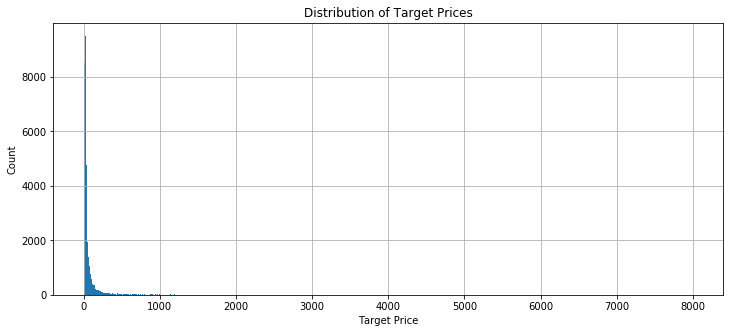

In [11]:
plt.figure(figsize = (12,5))
data.target_price.hist(bins = 1000)
plt.xlabel('Target Price')
plt.ylabel('Count')
plt.title('Distribution of Target Prices')
plt.show()

In [12]:
data.target_price.min()

2.09

In [13]:
data.target_price.max()

7994.99

Breaking down the distribution a little. This piece of code magnifies the earlier graph

In [14]:
data.target_price[(data.target_price < 2000)].shape

(49950,)

Most of the prices lie between 2.09 to 2000. Only about 50 values from 50000 lie above that. 

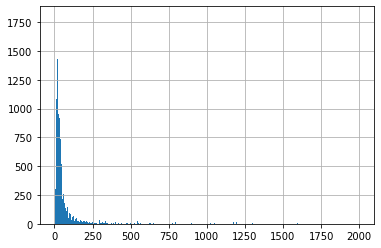

In [15]:
# Call 
data.target_price[(data.target_price < 2000)].hist(bins = 2000)

Most of the prices lie below 100

### Are there rows where all benchmark prices are Missing?

In [16]:
benchmarks = data[['benchmark_price_1','benchmark_price_2','benchmark_price_3','benchmark_price_4','benchmark_price_5','benchmark_price_6','target_price']]

It looks like 861 rows,  have missing benchmarks in them. A decision must be made on whether to include this rows, or delete them

In [17]:
(benchmarks.isnull().sum(axis = 1) == 6).sum()

861

### For all non null benchmarks, can we try to find the correlations between each of these benchmarks?

In [18]:
print(benchmarks[(~benchmarks.isnull().sum(axis = 1) == -1)].shape)
benchmarks[(~benchmarks.isnull().sum(axis = 1) == -1)].corr()

(248, 7)


,benchmark_price_1,benchmark_price_2,benchmark_price_3,benchmark_price_4,benchmark_price_5,benchmark_price_6,target_price
benchmark_price_1,1.000000,0.957322,0.839075,0.965857,0.977525,0.970921,0.975489
benchmark_price_2,0.957322,1.000000,0.842333,0.951699,0.961799,0.953557,0.970727
benchmark_price_3,0.839075,0.842333,1.000000,0.922940,0.875560,0.899535,0.870104
benchmark_price_4,0.965857,0.951699,0.922940,1.000000,0.978102,0.982921,0.977551
benchmark_price_5,0.977525,0.961799,0.875560,0.978102,1.000000,0.988227,0.992236
benchmark_price_6,0.970921,0.953557,0.899535,0.982921,0.988227,1.000000,0.988842
target_price,0.975489,0.970727,0.870104,0.977551,0.992236,0.988842,1.000000


It looks like there are only 248 rows that are completely full, or have a no missing value.
Further, we can see huge positive correlations between benchmark 4,5 and 6. This helps us in identifying that there is some kind of linear relationship between the 2 variables. 

It is also interesting to see how strongly the target price correlates linearly to benchmark_5 (0.992) and benchmark_6 (0.988)

However, it is difficult to generalize this to the entire dataset, because our sample size here is small.

Lets try to find patterns on our entire benchmark data, we exclude the categorical features amongst it. Further, pd.corr() will ignore missing values

In [19]:
corr_matrix = data[['benchmark_price_1','benchmark_price_2','benchmark_price_3','benchmark_price_4','benchmark_price_5','benchmark_price_6','target_price']].corr()

In [20]:
corr_matrix

,benchmark_price_1,benchmark_price_2,benchmark_price_3,benchmark_price_4,benchmark_price_5,benchmark_price_6,target_price
benchmark_price_1,1.000000,0.839790,0.612506,0.647540,0.896281,0.888014,0.799424
benchmark_price_2,0.839790,1.000000,0.715006,0.919756,0.900067,0.943660,0.931652
benchmark_price_3,0.612506,0.715006,1.000000,0.921511,0.747113,0.790749,0.772949
benchmark_price_4,0.647540,0.919756,0.921511,1.000000,0.819853,0.862802,0.909431
benchmark_price_5,0.896281,0.900067,0.747113,0.819853,1.000000,0.951136,0.962138
benchmark_price_6,0.888014,0.943660,0.790749,0.862802,0.951136,1.000000,0.922491
target_price,0.799424,0.931652,0.772949,0.909431,0.962138,0.922491,1.000000


Thus we can see that the correlation values have gone down, when the entire dataset was considered. eg. Correlation between benchmark_5 and benchmark_6 is now 0.95, which is still a strong correlation coefficient. However some of the strong relationships we saw earlier are not as strong when the entire data is considered. eg. benchmark_price_4 vs benchmark_price_1. 

The target price is highly linearly correlated to benchmark_price_6

Further, the correlation between the target price as well as the benchmark prices has fallen to smaller values as well.

### Analyze target prices as a function of product category 

This could help us impute missing values per category, rather than on the entire data

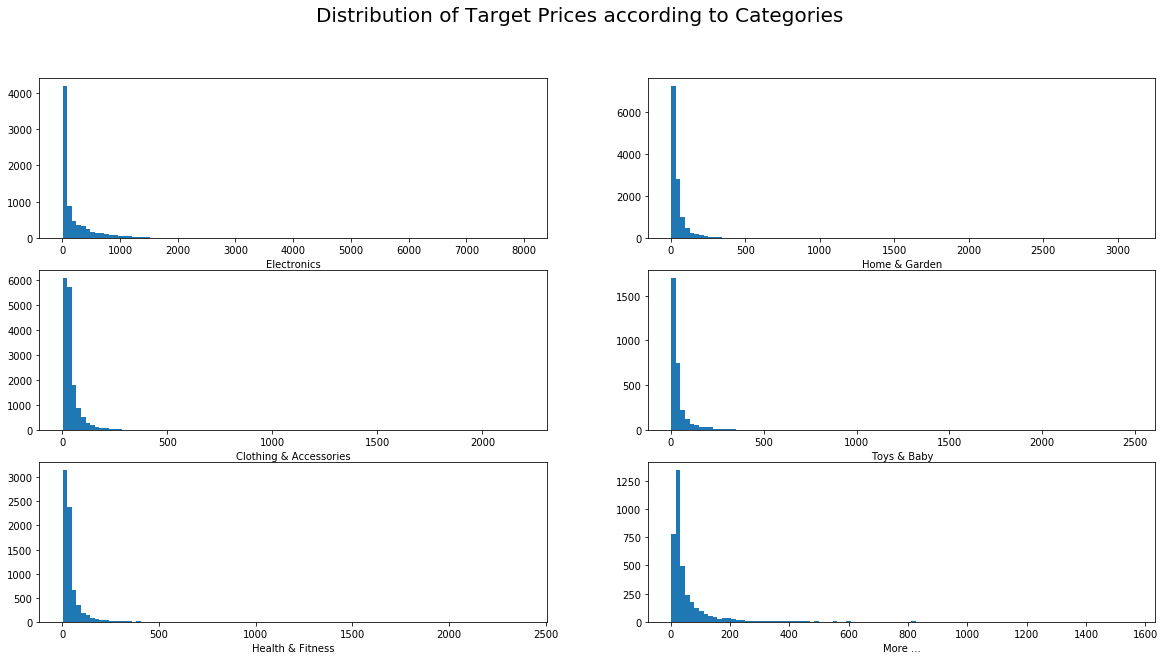

In [21]:
cats = data.category.unique()

fig = plt.figure(figsize =(20,10))

for i in range(len(cats)):
    ax = fig.add_subplot(3,2,i+1)
    ax.hist(data[data['category'] == cats[i]]['target_price'],bins = 100)
    ax.set_xlabel(cats[i])

fig.suptitle('Distribution of Target Prices according to Categories',size = 20)
fig.show()

Most of the categories follow a similar distribution to the entire dataset, we saw earlier how most of the prices were concentrated around 100. There are some obvious observations we can make, for example the category More is spread out compared to the others, and Electronics has the highest priced product. 

### Analyze target prices as a function of shipping category

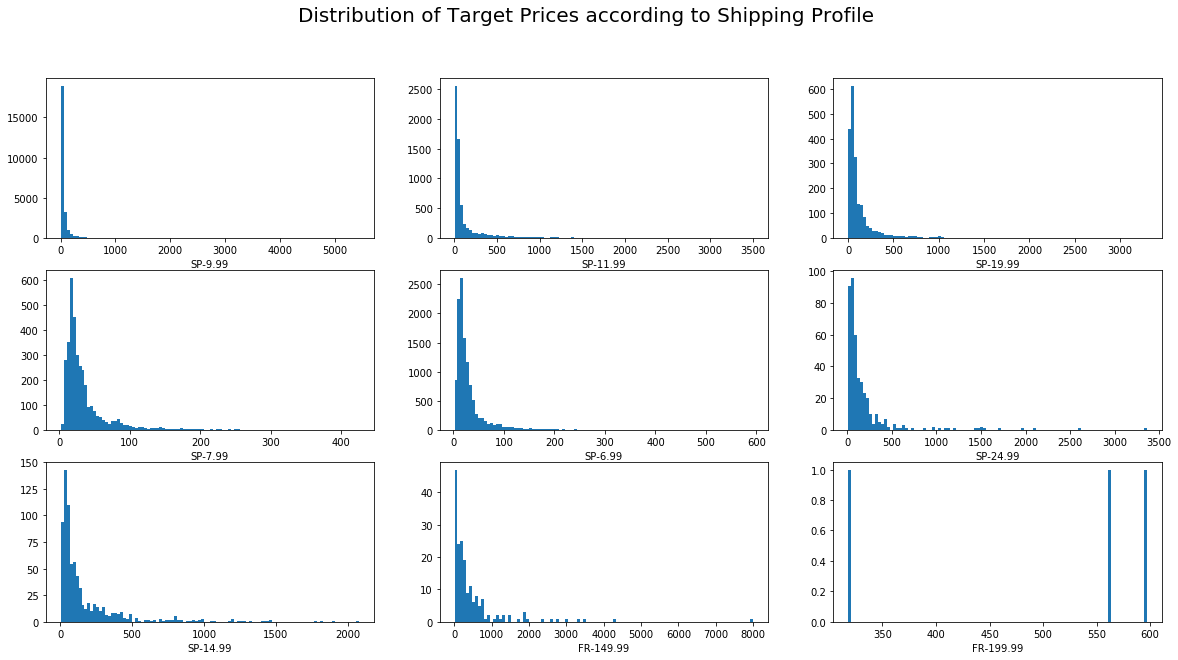

In [22]:
cats = data.shipping_profile.unique()

fig = plt.figure(figsize =(20,10))

for i in range(len(cats)):
    ax = fig.add_subplot(3,3,i+1)
    ax.hist(data[data['shipping_profile'] == cats[i]]['target_price'],bins = 100)
    ax.set_xlabel(cats[i])

fig.suptitle('Distribution of Target Prices according to Shipping Profile',size = 20)
fig.show()

FR-199.99 has only 3 values and has a uniform distribution. Rest of the shipping profiles follow a similar long tailed distribution, with SP-9.99 being the most common.

### What does the distribution of Manufacturers look like? 

In [23]:
print('Number of unique manufacturers - %d'%len(data.manufacturer_id.unique()))
print('Number of manufacturers that are seen only once - %d'%len(data.manufacturer_id.value_counts()[data.manufacturer_id.value_counts() == 1]))

Number of unique manufacturers - 15472
Number of manufacturers that are seen only once - 9968


This shows how around 66% of the manufacturers are seen only once. We may have to find a way to encode this data for unseen values.

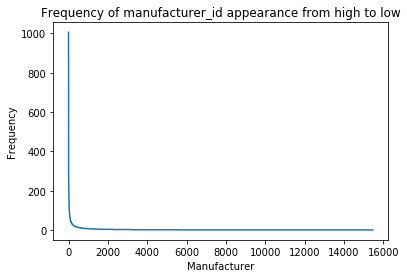

In [24]:
plt.plot(data.manufacturer_id.value_counts().tolist())
plt.title('Frequency of manufacturer_id appearance from high to low')
plt.xlabel('Manufacturer')
plt.ylabel('Frequency')
plt.show()

### Frequency encoding on  Manufacturer ID

We use frequency encoding to fit our manufacturer data. Frequency encoding might help because our ML algorithms will take into account the frequency as a weight, and take decisions on the basis of that. It will also help us reduce dimensionality , as one-hot does will definitely bloat dimensionality.

In [25]:
data = data.set_index('manufacturer_id').join(data.manufacturer_id.value_counts()).reset_index().drop('index',inplace = False,axis = 1)

Here we can see that manufacturer_id has been transformed to its frequency

In [26]:
data.head()

,product_id,benchmark_price_1,benchmark_price_2,benchmark_price_3,benchmark_price_4,benchmark_price_5,benchmark_price_6,category,shipping_profile,target_price,manufacturer_id
0,2,699.99,NaN,NaN,NaN,NaN,NaN,Electronics,SP-11.99,655.99,322
1,204,799.00,591.85,697.22,NaN,NaN,NaN,Electronics,SP-19.99,591.89,322
2,208,399.99,NaN,319.00,294.99,NaN,NaN,Electronics,SP-14.99,298.99,322
3,229,687.48,413.35,627.12,NaN,NaN,NaN,Electronics,SP-11.99,429.99,322
4,285,599.99,480.00,549.99,369.99,NaN,NaN,Electronics,SP-11.99,479.99,322


### What does Benchmark 1 look like? 

We focus on benchmark one solely because benchmark one has around 40000/50000 values filled.  Thus, the goal is to impute benchmark 1 with a simple imputating strategy and impute other values from the relationships obtained from correlation analysis.

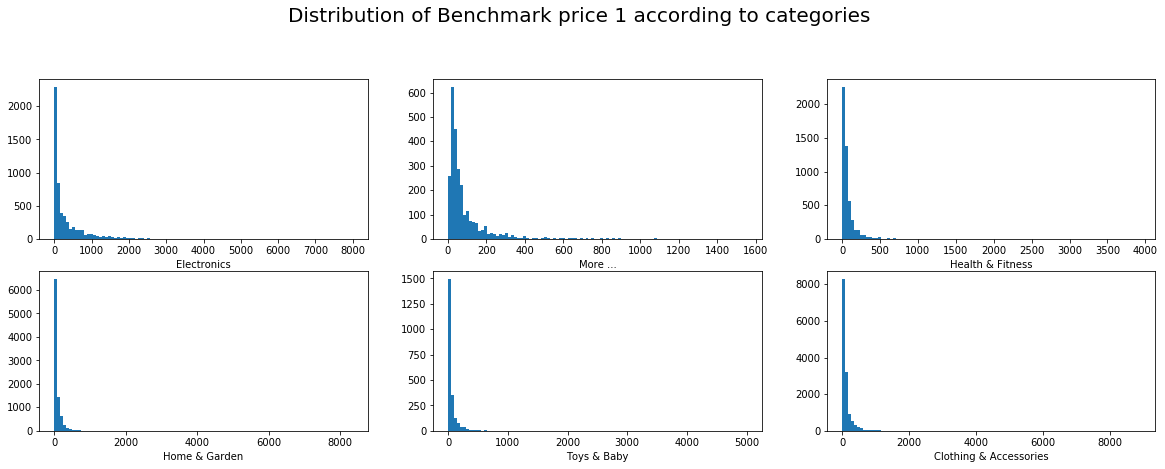

In [27]:
cats = data.category.unique()

fig = plt.figure(figsize =(20,10))

for i in range(len(cats)):
    ax = fig.add_subplot(3,3,i+1)
    ax.hist(data[data['category'] == cats[i]]['benchmark_price_1'],bins = 100)
    ax.set_xlabel(cats[i])

fig.suptitle('Distribution of Benchmark price 1 according to categories',size = 20)
fig.show()

### Drop the product column

In [28]:
data.drop(labels = 'product_id', axis = 1, inplace = True)

### Convert to One-Hot Encoding prior to fitting data

In [29]:
entire_data = pd.get_dummies(columns=['shipping_profile','category'],data=data)

entire_y = entire_data['target_price']
entire_x = entire_data.drop('target_price',axis = 1)

We cannot convert manufacturer_id via One Hot. This would bloat dimensionality unnecessarily. 

### Missing Data imputation

Before imputing missing data, we split our data into train, val, test to simulate a production environment.

In [30]:
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y = train_test_split(entire_x,entire_y,random_state = 20 ,test_size = 0.2)

From our correlation analysis ,we can easily figure out that there are relationships between benchmark5 and benchmark6 and benchmark6 and benchmark2. Thus, we impute these 3 variables using a Linear Regressor estimator, and further impute the others using a non-linear KNN estimator approach.

In [31]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer

In [32]:
lr = LinearRegression()

it_imp = IterativeImputer(estimator=lr)
it_imp.fit(train_x[['benchmark_price_2','benchmark_price_5','benchmark_price_6']])
train_x[['benchmark_price_2','benchmark_price_5','benchmark_price_6']] = it_imp.transform(train_x[['benchmark_price_2','benchmark_price_5','benchmark_price_6']])

knn_imp = KNNImputer()
train_imputed = knn_imp.fit_transform(train_x)

In [33]:
test_x[['benchmark_price_2','benchmark_price_5','benchmark_price_6']] = it_imp.transform(test_x[['benchmark_price_2','benchmark_price_5','benchmark_price_6']])
test_x = knn_imp.transform(test_x)

### Initial modeling and evaluation

In [34]:
from sklearn.metrics import mean_absolute_error

def evaluateModel(model,test_x,test_y):
    print('*'*50)
    print('R squared %f'%model.score(test_x,test_y))
    print('MAE score is %f'%(mean_absolute_error(model.predict(test_x),test_y)))
    print('*'*50)

In [35]:
### Initially let's try te simplest model - Linear Regressor, just on the benchmarks. 
# This model takes only the benchmark prices as training data (First 6)

lrmodel = LinearRegression()
lrmodel.fit(train_imputed[:,:6],train_y)
print('Evaluation for Linear Regressor with only benchmark features')
evaluateModel(lrmodel,test_x[:,:6],test_y)

Evaluation for Linear Regressor with only benchmark features
**************************************************
R squared 0.759865
MAE score is 31.381910
**************************************************


In [36]:
### Linear model with all features used.

lrmodel_all = LinearRegression()
lrmodel_all.fit(train_imputed,train_y)
print('Evaluation for Linear Regressor taking into account all features')
evaluateModel(lrmodel_all,test_x,test_y)

Evaluation for Linear Regressor taking into account all features
**************************************************
R squared 0.775457
MAE score is 33.421343
**************************************************


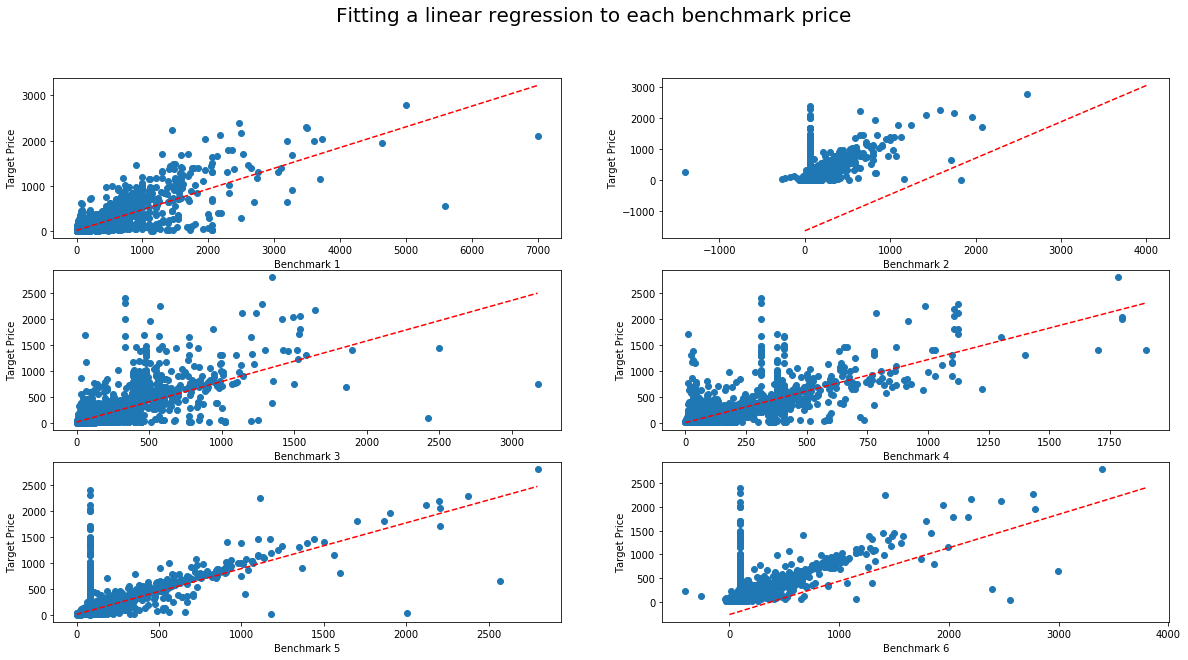

In [37]:
### Linear model with each individual benchmark.

# 6 is known to be the number of benchmark columns
fig = plt.figure(figsize =(20,10))

def linear_interpret(model,vals):
    # Y = ax + b
    return vals * model.coef_ + model.intercept_
    
for i in range(6):
    ax = fig.add_subplot(3,2,i+1)
    lrmodel_all = LinearRegression()
    lrmodel_all.fit(train_imputed[:,i:i+1],train_y)
    ax.scatter(test_x[:,i:i+1],test_y)
    vals = np.arange(np.min(test_x[:,i:i+1]),np.max(test_x[:,i:i+1]))
    ax.plot(linear_interpret(lrmodel_all,vals),linestyle = 'dashed',color = 'red')
    ax.set_xlabel('Benchmark %d'%(i+1))
    ax.set_ylabel('Target Price')
    #evaluateModel(lrmodel_all,test_x[:,i:i+1],test_y)

fig.suptitle('Fitting a linear regression to each benchmark price',size = 20)
fig.show()

Thus we see a slight improvement in r_squared score when we use the entire dataset, not only the benchmarks. But R2 does not give us an idea of what the average error looks like. We can see that the MAE increases when we take into account all features. We can infer that there is some feature reduction strategy we can apply if needed.

Further, when we plot each benchmark price to the target, we realize that apart from Benchmark 1, there are obvious vertical patterns of repetition that are difficult to fit linearly.

Also, an MAE of 33 dollars is not very impressive, mostly because most of our target prices are below 100. Ideally we'd like a solution in which the MAE is ~2-5$.
This sparks a need to use a model that does not over simplify. 

Below we attempt to fit regressors with models capable of capturing more variance. The goal is to use regressors from different sklearn classes , eg. one tree based method, one linear method, one optimization based method to get a good sense of what works well.

In [38]:
from sklearn.ensemble import RandomForestRegressor

print('\nEvaluating Random Forest Regressor')
rf = RandomForestRegressor(n_estimators = 200)
rf.fit(train_imputed,train_y)
evaluateModel(rf,test_x,test_y)


Evaluating Random Forest Regressor
**************************************************
R squared 0.860631
MAE score is 18.369603
**************************************************


Text(0.5, 1.0, 'Importance of features (Ratio)')

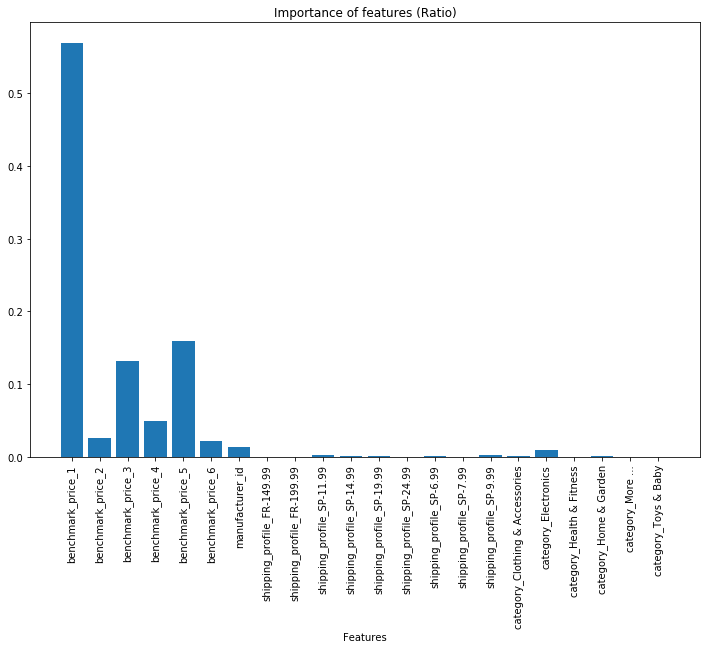

In [39]:
plt.figure(figsize = (12,8))
plt.bar(x = range(len(rf.feature_importances_)),height = rf.feature_importances_)
plt.xlabel('Features')
plt.xticks(ticks = range(train_x.shape[1]),labels = train_x.columns,rotation = 'vertical')
plt.title('Importance of features (Ratio)')

This shows how important the first benchmark is in predicting the target value. One reason behind this can be because the benchmark_price_1 had the most complete values, and our imputing strategy may not be the most optimal

Lastly, lets evaluate a model that is prone to overfit, and see if we can regularize from there. Also, a quantile loss function will allow us to generate a prediction interval, which will help measure uncertainty.

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

alp = 0.75
gbm = GradientBoostingRegressor(n_estimators = 200,loss = 'quantile',alpha = alp)
gbm.fit(train_imputed,train_y)
y_upper = gbm.predict(test_x)

gbm.set_params(alpha = 1 - 0.75)

gbm.fit(train_imputed,train_y)
y_lower = gbm.predict(test_x)

gbm.set_params(loss = 'ls')
gbm.fit(train_imputed,train_y)
y_pred = gbm.predict(test_x)

In [41]:
evaluateModel(gbm,test_x,test_y)

**************************************************
R squared 0.852585
MAE score is 21.767605
**************************************************


#### Final Model Choice - RandomForestRegressor
We thus observe from the MAE scores that the best performing model given the current data transformations and understanding does turn out to be RandomForestRegressor. Future implementation would definitely include breaking the data distribution such that different models are trained on different subsets of the data.  An ensemble of different methods can also help enhance predictions , but in interest of time, only one model is sufficient to work with

In order to battle Overfitting, we refit our RandomForest method on a smaller subset, using hyperparameter tuning methods like Randomized search and K-fold cross validation 

In [63]:
import pickle

mpath = os.path.join(os.path.curdir,'model_dumps')
if not os.path.exists(mpath):
    os.mkdir(mpath)

pickle.dump(it_imp,open(os.path.join(mpath,'iterative_imp.pkl'),'wb'))
pickle.dump(knn_imp,open(os.path.join(mpath,'knn_imp.pkl'),'wb'))
pickle.dump(rf,open(os.path.join(mpath,'forest_model.pkl'),'wb'))

### Model Deployment and productionizing

In [87]:
'''
This class serves to be an API for our price model. 
The only exposed method is the predict method, the rest is abstracted from the user. This file, along with the below requirements.txt would help other data analysts replicate this environment
For more sophisticated dependency management, an example of how we could use docker containers and poetry can be seen below.

This class can be packaged in a Docker along with the model (if not too huge), and be run as a containerized application , using the Docker file below.
'''
import pickle 
import os
from sklearn.metrics import mean_absolute_error

class priceModel:
    def __init__(self,path,test,test_y):
        assert isinstance(test,pd.DataFrame)
        self.path = path
        # Initialize imputers
        self.it_imp = None
        self.knn_imputer= None
        
        # Initialize data
        self.test = test
        self.test_y = test_y
        
        # Initialize model
        self.rfmodel = None
        
        self._loadPriceModel()
        self._transform()
 
    
    def _loadPriceModel(self):
        '''
        This method loads the latest pricing model from the model storage directory. This may include intermediate imputers as well.
        '''
        assert os.path.exists(os.path.join(self.path,'iterative_imp.pkl'))
        assert os.path.exists(os.path.join(self.path,'knn_imp.pkl'))
        assert os.path.exists(os.path.join(self.path,'forest_model.pkl'))
        
        self.it_imp = pickle.load(open(os.path.join(self.path,'iterative_imp.pkl'),'rb'))
        self.knn_imputer = pickle.load(open(os.path.join(self.path,'knn_imp.pkl'),'rb'))
        self.rfmodel = pickle.load(open(os.path.join(self.path,'forest_model.pkl'),'rb'))
        
        assert rf.n_features_ == self.test.shape[1]

        
    def _transform(self):
        '''
        This methods abstracts all the imputation and transformation activities needed.
        '''
        
        self.test[['benchmark_price_2','benchmark_price_5','benchmark_price_6']] = self.it_imp.transform(self.test[['benchmark_price_2','benchmark_price_5','benchmark_price_6']])
        self.test = self.knn_imputer.transform(self.test)
        
        # Test that the shape remains the same after transformation. 
        assert self.rfmodel.n_features_ == self.test.shape[1]
        
    
    def predict(self):
        '''
        An inference function that takes in the data and returns an evaluation. 
        '''
        return self.rfmodel.predict(self.test)
    
    def eval_and_predict(self,criterion):
        '''
        Given a criterion, evaluate and also return predictions. It is up to the users to capture the predictions or not.
        '''
        assert criterion in ['mae','r2']
        
        preds = self.rfmodel.predict(self.test)
        
        if criterion == 'mae':
            print('MAE score is %f'%mean_absolute_error(preds,self.test_y))    
        else:
            print('R squared %f'%self.rfmodel.score(self.test,self.test_y))
            
        return preds

How to use this API

In [90]:
# Developer inputs path of model
model_path = mpath
# Data Source
train_x,test_x,train_y,test_y = train_test_split(entire_x,entire_y,random_state = 20 ,test_size = 0.2)

pm = priceModel(model_path,test_x.head(10),test_y.head(10))
preds = pm.eval_and_predict(criterion = 'mae')

MAE score is 4.508471


## Dependency and project management workflow demonstration meant to be demonstrate a flow of activities.

### STEP 1 Data Scientist creates directory structure of the project, using poetry. 

poetry new price-model

poetry add sklearn scipy numpy

### STEP 2 This would create a directory structure that looks like this

git add .

git commit -m "Adding price project"

git push origin master

### STEP 3 Application developer

git pull

poetry install 
(Updates his environment to changes made)

poetry run price_model.py

(Developer makes a change to the project called changed_file.py)

git add changed_file.py

poetry add yaml (Adding other dependencies that the application developer needs)

git push

### A simpler version would just use the requirements.txt file along with git for version control.

## DOCKERFILE for kubernetes deployment

<br>

FROM python3

MAINTAINER Akash Shah (akashshah59@gmail.com)

MKDIR /model

COPY model.pkl /model #copy from local to container

RUN sudo apt-get install && \
    pip install requirements.txt

ENTRYPOINT ['python3','price-model.py','test-data-path']

# Commands to build and run this docker

docker build -f /path/to/a/Dockerfile .

(Test docker locally using <b>docker run</b>) <br>
(Finally create a pod with docker specifications inside the .yaml)

kubectl create pod price-model.yaml